# Twisted Gaussian (banana) toy LogPDF

This distribution (described [here](http://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html)) has a curved "banana" shape. The problem can be more more or less difficult by changing the "bananicity" parameter `b`.

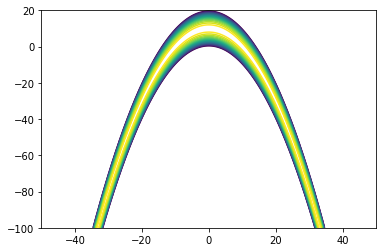

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Contour plot of pdf
levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels = levels)
plt.show()

We can also sample independently from this toy LogPDF, and add that to the visualisation:

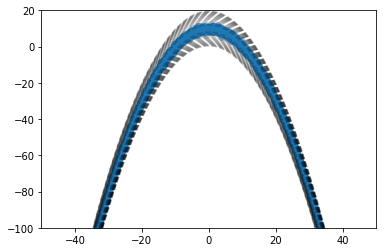

In [2]:
direct = log_pdf.sample(15000)

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(direct[:, 0], direct[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.show()

We now try to sample from the distribution with MCMC:

In [3]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(-25, 25, size=(3, 2))
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.HaarioBardenetACMC)

# Stop after 10000 iterations
mcmc.set_max_iterations(3000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[1000:] for chain in chains]

Running...
Done!


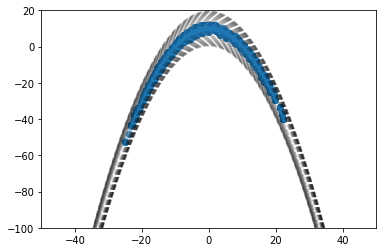

In [4]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(stacked[:, 0], stacked[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.show()

Now check how close the result is to the expected result, using the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), and compare this to the result from sampling directly.

In [5]:
print(log_pdf.kl_divergence(stacked))
print(log_pdf.kl_divergence(direct))

1.69270294721
8.72282979447e-05


Hamiltonian Monte Carlo fares much better on this curved density.

In [8]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(-25, 25, size=(3, 2))
sigma0 = [5, 5]
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.HamiltonianMCMC, sigma0=sigma0)

# Stop after 10000 iterations
mcmc.set_max_iterations(3000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

chains1 = [chain[1000:] for chain in chains]
stacked = np.vstack(chains1)

print(log_pdf.kl_divergence(stacked))
print(log_pdf.kl_divergence(direct))

Running...


pints/_mcmc/_hamiltonian.py:284: RuntimeWarning: invalid value encountered in subtract
  self._momentum -= self._scaled_epsilon * self._gradient
pints/toy/_twisted_gaussian_banana.py:67: RuntimeWarning: invalid value encountered in double_scalars
  y[1] += self._b * ((x[0] ** 2) - self._V)
pints/toy/_twisted_gaussian_banana.py:78: RuntimeWarning: invalid value encountered in double_scalars
  -x[0] / (50 * V) - 4 * b * x[0] * (b * (x[0]**2 - V) + x[1])
pints/toy/_twisted_gaussian_banana.py:80: RuntimeWarning: invalid value encountered in double_scalars
  dy_first = -b * (x[0]**2 - V) - x[1]
pints/_mcmc/_hamiltonian.py:290: RuntimeWarning: invalid value encountered in subtract
  self._momentum -= self._scaled_epsilon * self._gradient * 0.5
pints/_mcmc/_hamiltonian.py:302: RuntimeWarning: overflow encountered in square
  proposed_K = np.sum(self._momentum**2 / 2)


Done!
76.1477311635
8.72282979447e-05


Visualising the path of a single HMC chain, we see that it moves naturally along contours although does occassionally suffer from divergent iterations (red dots) in the neck of the banana due to the varying posterior curvature throughout the domain.

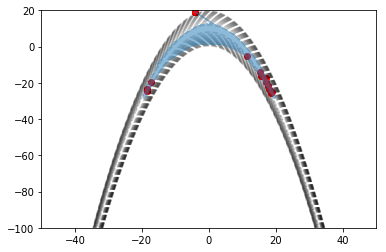

In [18]:
divergent_transitions = mcmc.samplers()[0].divergent_iterations()
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.plot(chains[0][:, 0], chains[0][:, 1], alpha=0.5)
plt.scatter(chains[0][divergent_transitions, 0], chains[0][divergent_transitions, 1], color='red')
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.show()